## Import modules

In [1]:
### Imports standard Packages

import itertools
import math
import time
import numpy as np
from easydict import EasyDict as edict
import tempfile
import pandas as pd
import glob
import os
import sys

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset 
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset 

from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr




C:\Users\jeane\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\jeane\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [3]:
sys.path.append('../')
sys.path.append("../binary_stochastic_neurons")
sys.path.append("../binary_stochastic_neurons/distributions")

In [4]:
from binary_stochastic_neurons.utils import Hardsigmoid
from binary_stochastic_neurons.activations import DeterministicBinaryActivation, StochasticBinaryActivation

from utils.load_data import load_complex_nifty
from utils.MRI_util import transform_image_to_kspace, transform_kspace_to_image, transform_kspace_to_image_torch

In [5]:
use_cuda=True and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
CUDA_LAUNCH_BLOCKING=1

In [6]:
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## <font color='darkblue'> Some functions for data pre processing</font>

In [7]:
def transform_coil_to_column(kspaces): 
    
    """kspaces : (nslices, ncoils, h, w)
    this function will stack the coil of all slice into columns. eg : it will return a 2D array of shape [n , ncoils]. See appendix B of the report """
    assert kspaces.ndim ==4
    
    b = kspaces.reshape(kspaces.shape[0], kspaces.shape[1], -1)
    
    return np.stack( [np.hstack( [ b[i,j,:] for i in range(b.shape[0]) ] ) for j in range(b.shape[1]) ],axis =1)

In [8]:
def normalize( data, mse_loss_type ='norm', scaling_factor = 1e3):  #from mriGANdata.py : normalize(self, data) ; Swetali codes    
    '''
        Options: 
            norm => divide by norm of the signal
            raki => multiply by 0.015/max(data)
            weight => unnormalized data
        returns the normalized input
    '''
    if(mse_loss_type == 'norm'):
        normalize = 1/np.max(abs(data[:])) #1/np.linalg.norm((data))
    else:
        normalize = scaling_factor

    norm_data = np.multiply(data,normalize) 
    return norm_data

In [9]:
class own_minmaxscaler:

    def __init__(self, config, base_scaler=MinMaxScaler()):
        self.base_scaler = base_scaler
        self.config = config


    def fit(self,train_data):
                       
        assert train_data.ndim ==2  and  train_data.shape[1]== self.config.ncoils  and  np.iscomplexobj(train_data)==False ## we want x_train to be of shape [n,ncoils] ==> the complexe [N,ncoils,121,145] should be set to this shape
        self.base_scaler.fit( np.abs(train_data)  ) ## get the min and max by doing : base_scaler.data_max_ ; base_scaler.data_min_

    def transform(self,x):
        assert x.ndim == 4 and x.shape[1] == self.config.ncoils
        
        max_in_coil =(self.base_scaler.data_max_).reshape(1, self.config.ncoils, 1, 1)
        return x/max_in_coil   

    def inverse_transform(self,x):
        
        max_in_coil =(self.base_scaler.data_max_).reshape(1, self.config.ncoils, 1, 1)
        return x* max_in_coil

    
    
def transform_data(x_train, x_test,config, scaler):      
    
    config = edict(config)
    ##x_train, x_test  are kspace of shape (n_examples, n_coil, h, w)
        
    
    train_size = x_train.shape[0]
    test_size= x_test.shape[0]
    

    complex_coil_column = transform_coil_to_column(x_train) ##the column here are complex value

    u_train =  np.vstack( (complex_coil_column.real, complex_coil_column.imag) ) 

    ##normalize kspace
    scaler.fit(u_train); x_train = scaler.transform(x_train) ; x_test= scaler.transform(x_test)

    print("max on train data : ",scaler.base_scaler.data_max_,"\n","min on train data : ", scaler.base_scaler.data_min_ )

    ##convert to torch tensor
    x_train = torch.stack((torch.from_numpy(x_train.real), torch.from_numpy(x_train.imag)),dim=-1).float().to(device) 
    x_test =  torch.stack((torch.from_numpy(x_test.real), torch.from_numpy(x_test.imag)),dim=-1).float().to(device)

    print("x_train shape :", x_train.shape)
    
    dataset = customDataset(x_train, torch.ones((train_size,1,1,1)).float().to(device))
    train_loader = DataLoader(dataset, batch_size=config.batch_size_train, shuffle=True )

    dataset_test = customDataset(x_test , torch.ones((test_size,1,1,1)).float().to(device))
    test_loader = DataLoader(dataset_test, batch_size=config.batch_size_test, shuffle=False )

    return train_loader, test_loader , scaler ##I return the scale , so that in prediction time I could rescale the predicted values    


## <font color='darkblue'> Data loading </font>



Note that here, we were elaborating the methodology on local. The way we load the data was different from the one used in grid search as described in the readme file. Here we took, four volumes, we mixed their slices and then we took part of the whole slices for train set and another part for test set.

In [10]:
def make_kspace_data(directory, seed = 229):
    
    ##load and prepare dataset 

    k_space_data = []


    #directories = glob.glob("/data1/home/jean-eudes.ayilo/Pytorch-MRI-ML-recon-V1.1/data/data_for_mask_learning/output/*")
    directories = glob.glob(directory) #"./data/output/ancien/*"

    for i in range(len(directories)):

        print(f"{i} :", "  ",f"{directories[i]}/imc.nii")

        imc = np.transpose(load_complex_nifty(f"{directories[i]}/imc.nii")[:,:,:,0,:], (2,3,0,1)) # nb slice,ncoil, h,w ; en chargeant avec load_complex_nifty,les données sont : (121, 145, 121, 1, 8); donc on enlève le 1 avec [:,:,:,0,:]

        k_space = normalize(transform_image_to_kspace(imc[50:90], dim=(2,3)))
        #k_space = transform_image_to_kspace(imc[50:89], dim=(2,3)) #tranform image to kspace, normalize, and then take the slice 50 to 90        

        k_space_data.append(k_space)                   


    k_space_data = np.vstack(k_space_data) 
    print("k_space_data : ",k_space_data.shape)       

    index = np.arange(k_space_data.shape[0]) 
    np.random.seed(seed)
    np.random.shuffle(index)
    index = list(index)

    k_space_data_schuffled =  k_space_data[index,...]     
        
    return k_space_data_schuffled

In [11]:
##load and prepare dataset 

k_space_data = []


#directories = glob.glob("/data1/home/jean-eudes.ayilo/Pytorch-MRI-ML-recon-V1.1/data/data_for_mask_learning/output/*")
directories = glob.glob("./data/output/ancien/*")

for i in range(len(directories)):
    
    print(f"{i} :", "  ",f"{directories[i]}/imc.nii")
    
    imc = np.transpose(load_complex_nifty(f"{directories[i]}/imc.nii")[:,:,:,0,:], (2,3,0,1)) # nb slice,ncoil, h,w ; en chargeant avec load_complex_nifty,les données sont : (121, 145, 121, 1, 8); donc on enlève le 1 avec [:,:,:,0,:]
    
    k_space = normalize(transform_image_to_kspace(imc[50:90], dim=(2,3)))
    #k_space = transform_image_to_kspace(imc[50:89], dim=(2,3)) #tranform image to kspace, normalize, and then take the slice 50 to 90        
            
    k_space_data.append(k_space)                   
    
            
k_space_data = np.vstack(k_space_data) 
print("k_space_data : ",k_space_data.shape)       


index = np.arange(k_space_data.shape[0]) 
np.random.seed(229)
np.random.shuffle(index)
index = list(index)

                        
k_space_data_schuffled =  k_space_data[index,...]                     


0 :    ./data/output/ancien\c_wm_0.8_gm_1.0_csf_0.4_br_1.0/imc.nii
1 :    ./data/output/ancien\c_wm_0.8_gm_1.0_csf_0.4_br_1.0_noise/imc.nii
2 :    ./data/output/ancien\c_wm_6.5_gm_8.5_csf_0.8_br_8.5/imc.nii
3 :    ./data/output/ancien\c_wm_6.5_gm_8.5_csf_0.8_br_8.5_noise/imc.nii
k_space_data :  (160, 8, 121, 145)


In [12]:
taux = 0.85
n_example = k_space_data.shape[0]

k_space_data_train,  k_space_data_test = k_space_data_schuffled[:int(taux*n_example)], k_space_data_schuffled[int(taux*n_example):]


In [13]:
print(k_space_data_train.shape)
print(k_space_data_test.shape)


(136, 8, 121, 145)
(24, 8, 121, 145)


In [14]:
class customDataset(Dataset):
    ''' 
        Create a dataloader which takes a tuples of kspaces and one fully sampled image

        Args:
        Kspace: kspace undesampled data
        acs: autocalibration data for training
        im_fs: fully sampled image for adversarial training
        mask: undersampling mask
    '''
    #

    def __init__(self, kspace, input_1):
        self.kspace = kspace
        self.input_1 = input_1
        #self.img_sos = img_sos

        
    def __getitem__(self, index):
        sample = {'kspace': self.kspace[index], 'input_1': self.input_1[index]} #, 'img_sos' : self.img_sos[index]}
        return sample
    
    def __len__(self):
        return len(self.kspace)


## <font color='darkblue'> Defining some layers/functions</font>


In [15]:
# https://github.com/a554b554/kWTA-Activation/blob/master/kWTA/models.py

class SparsifyBase(nn.Module):
    def __init__(self, sparse_ratio=0.5):
        super(SparsifyBase, self).__init__()
        self.sr = sparse_ratio
        self.preact = None
        self.act = None

    def get_activation(self):
        def hook(model, input, output):
            self.preact = input[0].cpu().detach().clone()
            self.act = output.cpu().detach().clone()
        return hook

    def record_activation(self):
        self.register_forward_hook(self.get_activation())


class Sparsify1D(SparsifyBase):
    def __init__(self, sparse_ratio=0.5):
        super(Sparsify1D, self).__init__()
        self.sr = sparse_ratio

    def forward(self, x):
        k = int(self.sr *x.shape[1])
        topval = x.topk(k, dim=1)[0][:, -1]
        topval = topval.expand(x.shape[1], x.shape[0]).permute(1 ,0)
        comp = ( x>=topval).to(x)
        return comp *x

class Sparsify1D_kactive(SparsifyBase):
    def __init__(self, k=1):
        super(Sparsify1D_kactive, self).__init__()
        self.k = k

    def forward(self, x):
        k = self.k
        topval = x.topk(k, dim=1)[0][:, -1]
        topval = topval.expand(x.shape[1], x.shape[0]).permute(1 ,0)
        comp = ( x>=topval).to(x)
        return comp *x
    
    
class Sparsify2D(SparsifyBase):
    def __init__(self, acs_points, acceleration = 4 ):
        super(Sparsify2D, self).__init__()
        self.acc = acceleration
        self.acs_points = acs_points

        self.preact = None
        self.act = None
        
    def forward(self, enlarge_x): 
    
        #enlarge_x = torch.zeros((1,1) + x.shape)

        #enlarge_x[:] = x
 
        layer_size = enlarge_x.shape[2]*enlarge_x.shape[3] # or x.shape[-2]*x.shape[-1]
        k = int(layer_size/self.acc) + self.acs_points # 

        tmpx = enlarge_x.view(enlarge_x.shape[0], enlarge_x.shape[1], -1)
        topval = tmpx.topk(k, dim=2)[0][:,:,-1]
        topval = topval.expand(enlarge_x.shape[2], enlarge_x.shape[3], enlarge_x.shape[0], enlarge_x.shape[1]).permute(2,3,0,1)
        comp = (enlarge_x >= topval).to(enlarge_x)
        return (comp*enlarge_x )[0,0,:,:]
      
    

class Sparsify1D_kactiveIOnline(SparsifyBase):
    def __init__(self, config):                                          
        super(Sparsify1D_kactiveIOnline, self).__init__()
                
        self.height_mask = config.mask_dim[0]
        self.width_mask = config.mask_dim[1]
        self.acc = config.acc ## acceleration en proportion
        self.slice_dim = config.slice_dim #tuple or list of the height and width of k-space
        
        self.k = int((self.slice_dim[0]*self.slice_dim[1])*self.acc)  
        self.k_per_under_mask = math.ceil((self.height_mask)*(self.width_mask) * self.k / (self.slice_dim[0]*self.slice_dim[1]))  
                                              
            
    def forward(self, x):#, k=0):
        #if (k==0):
        #  k = self.k
        #else:
        #  self.k = k
        topval = x.topk(self.k_per_under_mask, dim=1)[0][:, -1]
        topval = topval.expand(x.shape[1], x.shape[0]).permute(1 ,0)
        comp = ( x>=topval).to(x)
        return comp *x

        

In [16]:
##This is the conv layer which weight will be used to learn the mask. We integrate the acs to it; we didn't use this in mnist case

class Conv_Mask(nn.Module):
    
    def __init__(self, config ):## after, we will set kernel_size as an attribute. for the moment, we set acs to be an even number 
        
        
        super(Conv_Mask,self).__init__()
        
        self.h = config.mask_dim[0]
        self.w = config.mask_dim[1]
        self.acs = int(config.acs_full * config.acc) 
        self.acs_type = config.acs_type
        
        
        ##we want that the acs region we take depend on the acceleration; given  the full size of the acs , we take the corresponding part to the acceleration.comme full size je prends 40*40, oui c'est large
                   
                
        #self.conv_mask = nn.Conv2d(in_channels = 1, out_channels =1, 
                              #kernel_size = (self.h, self.w), groups=1, 
                              #bias=False, padding_mode='zeros',padding = (self.h - 1,self.w -1))
        
        self.conv_mask = nn.ConvTranspose2d(in_channels = 1, out_channels =1, kernel_size = (self.h, self.w), groups=1, bias=False)  

    def forward(self, x): #x is an input of 1                

        if self.acs_type == "column": ###do not use this for local mask 
            with torch.no_grad():
                self.conv_mask.weight[:, :, :, self.w//2 - self.acs//2 : self.w//2 + self.acs//2 +1] = 1e7 ##acs columns; with this large number the sigmoide should be close to 1
                #print("acs nb col :", (self.w//2 + self.acs//2 +1) - (self.w//2 - self.acs//2))
                
        elif self.acs_type == "square": ###do not use this for local mask 
            with torch.no_grad():
                self.conv_mask.weight[:, :, self.h//2 - self.acs//2 : self.h//2 + self.acs//2 +1, self.w//2 - self.acs//2 : self.w//2 + self.acs//2 +1] = 1e7                                        
                #print("acs shape :", (self.h//2 + self.acs//2 +1) - (self.h//2 - self.acs//2) , " ", (self.w//2 + self.acs//2 +1)- (self.w//2 - self.acs//2))
                
        elif self.acs_type == "no": 
            pass
        
        return self.conv_mask(x) 
    
    def get_nb_acs_points(self):  ##this will be add to the sparcity, in wta, so that we count the most 
        return int((self.conv_mask.weight==1e7).sum()) 
    

In [17]:

from torch.nn import Module, Sequential, ModuleList
from graphs.models.custom_layers.complex_layers import *


#SPIRiT as single conv layer with kernel(centre) = 0
class spirit2D(Module):
    
    def __init__(self, config):
        
        super(spirit2D,self).__init__()
        
        #define local variables
        self.config = config
        self.kernel_size = self.config.kernel1 
        self.ncoils = self.config.ncoils
        
        #self.nslices = config.batch_size #choosen_batch_size #self.config.nslices # REMPLACER PAR choosen_batch_size  divisible par le nombre d'exemple d'appprentissage total; le batch_size doit être = nb slice à processer
        self.conv1 = complexConv2d(in_channels= self.ncoils , out_channels=self.ncoils, kernel_size=self.kernel_size, bias=False, padding=(self.kernel_size[0]//2, self.kernel_size[1]//2))
    
    def forward(self, x):
        
        (x_real,x_img) = x[...,0],x[...,1]  
        
        with torch.no_grad():
            self.conv1.conv_r.weight[:, :, self.kernel_size[0]//2, self.kernel_size[1]//2] = 0
            self.conv1.conv_i.weight[:, :, self.kernel_size[0]//2, self.kernel_size[1]//2] = 0
        
        (x_real,x_img) = self.conv1(x_real,x_img)
        (x_real,x_img) =(torch.unsqueeze(x_real, 4), torch.unsqueeze(x_img, 4))
        
        return torch.cat((x_real,x_img),-1)

    
    
class SpiritConvBlock(Module):
    """
    Model block for spirit network.
    This model applied spirit to undersampled data. A series of these blocks can be stacked to form
    the full network.
    """

    def __init__(self, model):
        """
        Args:
            model: Spirit model.
        """
        super().__init__()

        self.model = model

    def forward(self,
        current_kspace: torch.Tensor,
        ref_kspace: torch.Tensor,
        mask: torch.Tensor):
        
        x = self.model(current_kspace)
        #data consistency
        out = torch.multiply(x,1-mask) + torch.mul(ref_kspace, mask) #torch.multiply(x,~mask) + ref_kspace
        
        return out
    
    
#Stack SpiritConv N times
class stackSpirit(Module):
    def __init__(self, config):
        
        super().__init__() 

        #define local variables
        self.config = config 
        
        #N times spirit is apply
        self.num_stacks = self.config.spirit_block
        
        self.body = ModuleList(
            [SpiritConvBlock(spirit2D(config)) for _ in range(self.num_stacks)]
        )

    def forward(self,
        masked_kspace: torch.Tensor,
        mask: torch.Tensor,):
        
        kspace_pred = masked_kspace.clone()

        for stack in self.body:
            kspace_pred = stack(kspace_pred, masked_kspace, mask)
        
        return kspace_pred



In [18]:
## this is not really used
class kspaceToImageToSOS(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, x):
        """ Computes the Fourier transform from k-space to image space
        along a given or all dimensions
        :param k: k-space data
        :param dim: vector of dimensions to transform
        :param img_shape: desired shape of output image
        :returns: data in image space (along transformed dimensions)
        """
        if not self.dim:
            self.dim = range(x.ndim)
        img = torch.fft.ifftshift(x, dim=self.dim)
        img = torch.fft.ifftn(img, dim=self.dim)
        img = torch.fft.fftshift(img,dim=self.dim)
        img = torch.sqrt(torch.sum(torch.square(torch.abs(img)),axis=(1)))
        #img = torch.unsqueeze(img,1) #add coil dimesnsion 
        return img


## <font color='darkblue'> Model definition and training</font>

In [19]:
class GaussianNoise(nn.Module):
    def __init__(self, stddev):
        super().__init__()
        self.stddev = stddev

    def forward(self, din):
        if self.training:
            #return din + torch.autograd.Variable(torch.randn(din.size()).cuda() * self.stddev)
            return din + torch.autograd.Variable(torch.randn(din.size()).to(device) * self.stddev)
        return din

In [20]:
class Net(nn.Module):

    def __init__(self, bin_act_type = "determinist", config=None):
        super(Net, self).__init__()

        self.img_h = config.slice_dim[0] ##nb rows for the inmput image
        self.img_w = config.slice_dim[1] ##nb col for the inmput image
        self.height_mask = config.mask_dim[0]
        self.width_mask = config.mask_dim[1]

        self.config = config
        self.std_noise = config.std_noise
        self.dropout_proba = config.dropout_proba                

        self.bin_act_type = bin_act_type
        
        self.my_conv_mask =  Conv_Mask(config)     
        
        self.DO1 = nn.Dropout(p = self.dropout_proba, inplace=False)
        self.noise = GaussianNoise(self.std_noise)

        self.binary_act_d = DeterministicBinaryActivation(estimator='ST')
        self.binary_act_s = StochasticBinaryActivation(estimator='ST')
        
        self.slope = config.slope #1.0
        #self.linear_sp = Sparsify1D_kactiveIOnline(self.height_mask, self.width_mask, k_per_under_mask = self.k_per_under_mask)
        self.linear_sp = Sparsify1D_kactiveIOnline(config) 
        print("Number of acquired points in the whole mask :",self.linear_sp.k ); print(f"Number of acquired points in the local mask of size {config.mask_dim} :",self.linear_sp.k_per_under_mask )
        print(f"acceleration : {self.linear_sp.acc}")


        self.spirit_nn = stackSpirit(self.config)
        
        #self.netToSOS = kspaceToImageToSOS(dim=(2,3))


    def forward(self, x, my_input_1):

        sig_output =  F.sigmoid((self.my_conv_mask(my_input_1)))       
        
        #sig_output= self.DO1(sig_output) 

        if self.bin_act_type == "determinist": # add noise and use deterministic binary activation 

          sig_output = self.noise(sig_output) # variance plus forte ici
          x2 = sig_output.view(sig_output.size()[0],-1)        
          x2 = self.linear_sp(x2)        
          wta_output = x2.view_as(sig_output) 
                 
          #wta_output = self.linear_sp(sig_output)        
             
          binary_mask = self.binary_act_d([wta_output, self.slope]) #shape [batch_size,1,self.height_mask, self.width_mask]
        
        elif self.bin_act_type == "stochastic": # don't add noise and use stochastic binary activation 
          x2 = sig_output.view(sig_output.size()[0],-1)        
          x2 = self.linear_sp(x2)        
          wta_output = x2.view_as(sig_output)    
          binary_mask = self.binary_act_s([wta_output, self.slope]) #shape :[batch_size,1,self.height_mask, self.width_mask], the mask is specific to each input ?


        ##ajuster la taille du masque à celle de l'image                                                                      
        binary_mask_adj = torch.tile(binary_mask[:,:,], (math.ceil(self.img_h/self.height_mask),math.ceil(self.img_w/self.width_mask)))[:,:,:self.img_h,:self.img_w] # x shape :[batch_size,n_channel,h,w] ; x.shape[-2] =x.shape[-1] = 28
        ##or change the "one" input and rewrite the conv mask with convtranspose  ,with stride = dim of mask...
        
        #print("binary_mask_adj shape: ", binary_mask_adj.shape)
        #print("x avant mul shape: ", x.shape)

      
        stack_binary_mask_adj = torch.stack((binary_mask_adj, binary_mask_adj), dim=-1,)
        #print("stack_binary_mask_adj ", stack_binary_mask_adj.shape) ; print("x.shape :", x.shape)
        x  = torch.mul(stack_binary_mask_adj,x)
        reconstructed_img = self.spirit_nn(x, stack_binary_mask_adj) ##more precisely it is the reconstructed kspace
        print()
                
        return reconstructed_img, binary_mask_adj, binary_mask  


## <font color='darkblue'> Define optimizer</font>

In [21]:


def define_opt(network, lr_mask = 1e-3, lr_other = 1e-2, algo =optim.Adam ):


    my_list = ['my_conv_mask.conv_mask.weight']

    params = list(filter(lambda kv: kv[0] in my_list, network.named_parameters()))
    base_params = list(filter(lambda kv: kv[0] not in my_list, network.named_parameters()))
    d = dict((y, x) for x, y in base_params)
    #optimizer_mask = optim.Adam(params,lr=0.001)
    #optimizer_model = optim.Adam(base_params,lr=0.01)

    optimizer = algo([ 
                                {'params': d}, 
                                {'params': network.my_conv_mask.conv_mask.parameters(), 'lr': lr_mask} 
                                ], lr=lr_other)
    return optimizer


In [22]:
#summary(model_det, [(8, 121, 145, 2),(1,1,1)]) ##if doesn't work comment : binary_mask = self.binary_act_d([wta_output, self.slope])

## <font color='darkblue'> Define test function, executed during each epoch </font>

In [23]:

def test_spirit_2(network,criterion,config, loader, scaler, fix_mask=False):

  network.eval()
  test_loss = 0
  output_array =[]
  input_array = []

  #print("*********** TEST *************")
  with torch.no_grad():
    for batch_idx, sample in enumerate(loader):
      input,  ones_data = sample['kspace'], sample['input_1']
    
      if fix_mask == False :
        output,  learned_mask_adj, learned_mask = network(input,ones_data) ##here the output is reconstruted kspace
      else:
        output,  learned_mask_adj, learned_mask = network(input) 
      
      #print(f"test : ,{len(output)}")

      if config.normalized_mse == True:
        test_loss += criterion(output, input)/criterion(input,torch.zeros(input.shape).cpu().to(device)).item() ## I am using this formulation to be sure that I divide the sum of sq by the same denominator            

      else :
        test_loss += criterion(output, input).cpu().item()*input.size(0) #criterion_MSE(output, input).item()*input.size(0)

      output_array.append(output) 
      input_array.append(input)        

  if config.normalized_mse == True:
    test_loss /= len(loader)
  else:
    test_loss /= len(loader.dataset) ##this is the loss on the whole test set

    
  print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))

  input_array = np.array(torch.vstack(input_array).cpu()) 
  output_array = np.array(torch.vstack(output_array).cpu()) 
    

  input_array_complex = input_array[...,0] +1j*input_array[...,1] ; input_array_complex = scaler.inverse_transform(input_array_complex) #rescaling
  input_array = transform_kspace_to_image(input_array_complex, dim=(2,3))
  input_array = np.sqrt(np.sum(np.square(np.abs(input_array)),axis=(1)))
  
  output_array_complex = output_array[...,0] +1j*output_array[...,1] ; output_array_complex = scaler.inverse_transform(output_array_complex) #rescaling
  output_array = transform_kspace_to_image(output_array_complex, dim=(2,3))
  output_array = np.sqrt(np.sum(np.square(np.abs(output_array)),axis=(1)))
    
    
  if fix_mask == False :
    fig, ax = plt.subplots(1,3, figsize=(15,6))
    ax[0].imshow(network.my_conv_mask.conv_mask.weight.data.clone().cpu()[0,0,:,:],cmap = "Greys_r")
    #ax[0].axis("off")
        
    #print(learned_mask.clone().cpu().shape)
    ax[1].imshow(learned_mask.clone().cpu()[0,0,:,:],cmap = "Greys_r")
    ax[1].axis("off")
    
    ax[2].imshow(learned_mask_adj.clone().cpu()[0,0,:,:],cmap = "Greys_r")
    ax[2].axis("off")
    plt.show()

  else :
    fig, ax = plt.subplots(1,2, figsize=(12,6))
        
    ax[0].imshow(learned_mask.clone().cpu()[0,0,:,:],cmap = "Greys_r")
    ax[0].axis("off")
    
    ax[1].imshow(learned_mask_adj.clone().cpu()[0,0,:,:],cmap = "Greys_r")
    ax[1].axis("off")
    plt.show()

  return input_array, output_array, test_loss.item(), learned_mask_adj 

In [24]:

def get_initial_weight_mask(network, data_loader):

  network.eval()

  with torch.no_grad():
    one_batch = next(iter(data_loader))    
    input, ones_data = one_batch['kspace'], one_batch['input_1']
    init_output, init_learned_mask_adj, init_learned_mask = network(input,ones_data)
    print(input.shape)


  return network.my_conv_mask.conv_mask.weight.data.clone().cpu()[0,0,:,:], init_learned_mask_adj.clone().cpu()[0,0,:,:]

## <font color='darkblue'> decreasing the noise during the training </font>

In [25]:
def get_std_noise(current_epoch, std_start,std_end, std_decay, std_slope = 1):    
    return std_end + (std_start - std_end) * math.exp(-std_slope * current_epoch / std_decay)

## <font color='darkblue'> Define training function </font>

In [26]:
def train_spirit_2(n_epochs, network, optimizer, config,loader, loader_test , scaler,saving_path = None,criterion=nn.MSELoss().to(device),fix_mask = False ):  
          
                
    train_losses = []
    test_losses = []
    learned_mask_adj_list = []
    weight_list = []
  
    if fix_mask == False :
        init_weight, init_learned_mask_adj = get_initial_weight_mask(network, loader) 

        weight_list.append(init_weight); learned_mask_adj_list.append(init_learned_mask_adj)

        plt.imshow(init_learned_mask_adj,cmap = "Greys_r")
        plt.axis("off")
        plt.title("initialisation mask")
        try:
            plt.savefig(os.path.join(saving_path,"initialisation_mask.png")) 
        except:
            pass    

    ##training loop
    for epoch in range(1, n_epochs + 1):
                
        running_loss = 0.0  
        
        if network.config.decrease_std:
            network.std_noise = get_std_noise(epoch, epsilon_start=config.epsilon_start, epsilon_end = config.epsilon_end, eps_decay= config.eps_decay, std_slope = config.std_slope)
            
            print(f"epoch {epoch} : std_noise : {network.std_noise}")
            
        
        network.train()
        for batch_idx, sample in enumerate(loader):                
            input, ones_data = sample['kspace'], sample['input_1']
            optimizer.zero_grad()

            if fix_mask == False :
              output,  learned_mask_adj, learned_mask = network(input,ones_data)
            else :
              #print("input",input.get_device())
              output,  learned_mask_adj, learned_mask = network(input)

            #loss = criterion(output, input)      #(sum of square)/batch_size*C*h*w

            if config.normalized_mse == True:
              loss = criterion(output, input)/criterion(input,torch.zeros(input.shape).to(device)) ## I am using this formulation to be sure that I divide the sum of sq by the same denominator            
            else :
              loss = criterion(output, input)  
            
            loss.backward()
            optimizer.step()

            if fix_mask == False :
              weight_list.append(network.my_conv_mask.conv_mask.weight.data.clone().cpu()[0,0,:,:]) ; learned_mask_adj_list.append(learned_mask_adj.clone().cpu()[0,0,:,:])

            #print("nb of pixels changed wrt previous mask : ", (torch.eq(learned_mask_adj_list[-2], learned_mask_adj_list[-1])==False).sum().item() )                        
            #print("nb of pixels changed wrt the initial mask : ", (torch.eq(learned_mask_adj_list[0], learned_mask_adj_list[-1])==False).sum().item()  )
            

            if config.normalized_mse == True:
              running_loss += loss.cpu().item()
            else:
              running_loss += loss.cpu().item() * input.size(0)  #(sum of square)/C*h*w
            
             

            if batch_idx % 64 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch, batch_idx * len(input), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item())) # this is the loss for a single batch : (sum of square)/batch_size*C*h*w
                
                #inp, out, _, _ = test_spirit_2(network,criterion,config, loader = loader_test,scaler = scaler,fix_mask=fix_mask) ; plotting_reconst(inp, out,n=4)


        if config.normalized_mse == True:
          epoch_loss = running_loss/len(loader)
        else:
          epoch_loss = running_loss/len(loader.dataset) #(sum of square)/n_examples*C*h*w; n_examples=batch_size*len(train_loader.dataset)

        train_losses.append(epoch_loss)
        print("test at the end of epoch")
        
        inp_, out_, end_test_loss, epoch_learned_mask_adj = test_spirit_2(network,criterion,config, loader = loader_test,scaler = scaler, fix_mask=fix_mask) ; test_losses.append(end_test_loss) 
        
        plt.imshow(epoch_learned_mask_adj[0,0,:,:].cpu(),cmap = "Greys_r")
        plt.axis("off")
        plt.title(f"mask_at_the_epoch_{epoch}")
        try:
          plt.savefig(os.path.join(saving_path,f"mask_at_the_epoch_{epoch}.png")) 
        except:
          pass

    if fix_mask == False :
      delta_pixels = [(torch.eq(learned_mask_adj_list[i], learned_mask_adj_list[i+1])==False).sum().item() \
                      for i in range(len(learned_mask_adj_list)-1)] #list of nb of pixels changed wrt previous mask 

      delta_weight = [((torch.linalg.vector_norm(torch.flatten(weight_list[i+1]-weight_list[i])))**2).item() \
          for i in range(len(weight_list)-1)] #list of diff in weight wrt previous weight


      delta0_pixels = [(torch.eq(learned_mask_adj_list[0],learned_mask_adj_list[i])==False).sum().item() \
                      for i in range(1,len(learned_mask_adj_list))] #nb of pixels changed wrt the initial mask

      delta0_weight = [((torch.linalg.vector_norm(torch.flatten(weight_list[i]-weight_list[0])))**2).item() \
                for i in range(1,len(weight_list))]  #list of diff in weight wrt initial weight


      fig, ax = plt.subplots(2,2, figsize=(20,10))

      ax[0,0].plot(range(1,len(delta_pixels)+1), delta_pixels)
      ax[0,0].set_title("nb of pixels changed wrt previous mask")
      ax[0,0].set_xlabel("iterations") # batch_size*nb_epochs
      ax[0,0].set_ylabel("nb of pixels")
      
      ax[0,1].plot(range(1,len(delta_weight)+1),delta_weight)
      ax[0,1].set_title("square diff in weight wrt previous weight")
      ax[0,1].set_xlabel("iterations") 
      ax[0,1].set_ylabel("weight square diff")

      ax[1,0].plot(range(1,len(delta0_pixels)+1),delta0_pixels)
      ax[1,0].set_title("nb of pixels pixels changed wrt the initial mask")
      ax[1,0].set_xlabel("iterations") 
      ax[1,0].set_ylabel("nb of pixels")

      ax[1,1].plot(range(1,len(delta0_weight)+1), delta0_weight)
      ax[1,1].set_title("diff in weight wrt initial weight")
      ax[1,1].set_xlabel("iterations") 
      ax[1,1].set_ylabel("weight square diff")

      try:
        plt.savefig(os.path.join(saving_path,"variations.png")) 
      except:
        pass
      plt.show() 

    return {"train_loss":train_losses, "test_loss":test_losses}  

## <font color='darkblue'> Additional evaluation functions </font>

In [27]:

def plotting_reconst(groundtruth, reconstruction,mask, loader,n=3, seed= None, saving_path =None):
  ##choose n between 3 and 6
  if seed != None:
    np.random.seed(seed)     
  random_index = np.random.choice(len(loader.dataset), n)

  fig, ax = plt.subplots(2,n, figsize=(15,6))
    #plot some examples of reconstruction and their groundtruth
  for t in range(n):

        ax[0,t].imshow(groundtruth[ random_index[t],:,:],cmap = "Greys_r")  
        ax[0,t].set_title("groundtruth")
        ax[0,t].axis("off")    

        ax[1,t].imshow(reconstruction[ random_index[t],:,:],cmap = "Greys_r")
        ax[1,t].set_title("reconstruction")
        ax[1,t].axis("off")
  try:
    plt.savefig(saving_path)
  except:
    pass
  plt.show()
    
        

In [28]:
def compute_ssim(groundtruth, reconstruction):    

    a = np.moveaxis(groundtruth, 1, -1) ## groundtruth dimension is (N,1,121,145); turn it to (N,121,145,1)
    b =  np.moveaxis(reconstruction, 1, -1)
    ssim_list = []
    psnr_list = []
    for i in range(a.shape[0]):
         ssim_i = ssim(a[i], b[i], data_range=abs(a[i].max() - b[i].min()), multichannel=True )
         psnr_i = psnr(a[i], b[i], data_range=abs(a[i].max() - b[i].min()))
    ssim_list.append(ssim_i)
    psnr_list.append(psnr_i)
    
    ##I double compute, just for comparison
    #ssim_2 = torch_ssim(torch.from_numpy(groundtruth),torch.from_numpy(reconstruction)); psnr_2 = torch_psnr(torch.from_numpy(groundtruth),torch.from_numpy(reconstruction))
    return {"test_ssim": np.mean(ssim_list), "test_psnr": np.mean(psnr_list)}#,"test_ssim2": ssim_2, "test_psnr2":psnr_2 }

In [29]:
def plot_loss(dictionay,title="reconstruction loss", test=False, saving_path = None):
  print("dictionay['test_loss']", dictionay["test_loss"])
  plt.figure()
  plt.plot(np.arange(1, len(dictionay["train_loss"])+1), dictionay["train_loss"], label = "train loss") 
  if test==True:
    plt.plot(np.arange(1, len(dictionay["test_loss"])+1), dictionay["test_loss"], label = "test loss")
  plt.title(f"{title}")
  plt.ylabel("loss")
  plt.xlabel("epoch") 
  plt.legend()
  try:
    plt.savefig(saving_path) 
  except:
    pass

  plt.show()
        
        

## <font color='darkblue'> Run function for learned mask and reconstruction </font>

In [30]:

def run_model(config, trainset= k_space_data_train, testset = k_space_data_test, critere = nn.MSELoss().to(device)):

    config = edict(config.copy())

    mask_dim =config.mask_dim; acs_type = config.acs_type ; acc =config.acc ;bloc = config.spirit_block ; std_noise=config.std_noise; kernel=config.kernel1 ; lr_mask=config.lr_mask ; lr_other=config.lr_other 
    
    dir_name = f"mask_dim_{mask_dim[0]}_{mask_dim[1]}_acs_type_{acs_type}_acc_{acc}_spirit_bloc_{bloc}_std_noise_{std_noise}_kernel_{kernel[0]}_{kernel[1]}_lr_mask_{lr_mask}_lr_other_{lr_other}"
    
    try:
        os.mkdir(config.main_directory) ##this will be created once, the others times an error will occur due to the multiplication of config that will need to create it again
    except:
        pass
        
    try:
        save_path = os.path.join(config.main_directory, dir_name)
        os.mkdir(save_path)  
    except:
        pass

    ##initialize scaler
    init_scaler = own_minmaxscaler(config)
    
    train_loader, test_loader, input_scaler = transform_data(trainset, testset,config, init_scaler)                      

    df = pd.DataFrame(columns=['mask_dim','acs_type','acc','bloc', 'kernel','std_noise','lr_mask','lr_other','test_ssim','test_psnr','test_loss',"test_loss_denorm"])
    

    print("#################################################################")

    print(f"mask_dim_{mask_dim}_acs_type_{acs_type}_acc_{acc}_spirit_bloc_{bloc}_std_noise_{std_noise}_kernel_{kernel[0]}_{kernel[1]}_lr_mask_{lr_mask}_lr_other_{lr_other}")

    reconst_network = Net(bin_act_type = "determinist", config =config).to(device)          

    ##Initialize spirit weights
    for m in reconst_network.modules():  ## from self.netS.apply(weights_init) mriPatchGanSpirit.py ; Pytorch-MRI-ML-recon-V1.1/graphs/weights_initializer.py
    
        if (type(m) in [nn.Conv2d]) and (m != reconst_network.my_conv_mask): 
            m.weight.data.normal_(0.0, 0.02)  

            
    optimizer_det = define_opt(reconst_network, lr_mask = config.lr_mask, lr_other = config.lr_other, algo = optim.Adam)
    
    dico_spirit_loss = train_spirit_2(config.n_epochs, reconst_network, optimizer_det, config, loader =train_loader, loader_test=test_loader,scaler = input_scaler, saving_path = save_path, criterion = critere )


    plot_loss(dico_spirit_loss,title=f"reconstruction loss for mask_dim_{mask_dim}_acs_type_{acs_type}_acc_{acc}_spirit_bloc_{bloc}_std_noise_{std_noise}_kernel_{kernel[0]}_{kernel[1]}_lr_mask_{lr_mask}_lr_other_{lr_other}", test=True, saving_path = os.path.join(save_path,"loss_curve.png"))


    test_input, test_output,test_loss, finalmask = test_spirit_2(reconst_network,criterion=critere, config =config, loader = test_loader, scaler = input_scaler)   

    ##the plotting is on denormalized input and output
    plotting_reconst(test_input , test_output,mask =finalmask,loader=test_loader, n=4, seed= 815, saving_path =os.path.join(save_path,"reconst_examples1.png"))
    plotting_reconst(test_input , test_output,mask =finalmask,loader=test_loader, n=4, seed= 23, saving_path =os.path.join(save_path,"reconst_examples2.png"))

    metrics = compute_ssim(test_input ,test_output)
    
    test_loss_denorm = critere(torch.from_numpy(test_input), torch.from_numpy(test_output)).item()

    print("average ssim and psnr on test set", metrics)
    
    line ={"mask_dim" :mask_dim,"acs_type":acs_type ,"acc":acc, "bloc" : bloc,  "std_noise" : std_noise, "kernel" :kernel,  "lr_mask" :lr_mask , "lr_other": lr_other}

    line.update(metrics); line["test_loss"] = test_loss ; line["test_loss_denorm"] = test_loss_denorm

    df = df.append(line, ignore_index=True) 

    df.to_csv(os.path.join(config.main_directory, dir_name,"result_grid_search.csv"), sep='\t',index=True)                                                 
  
    return finalmask

    print("##########   FIN   ##########")

max on train data :  [0.97721912 0.79243795 0.65691147 0.81250615 0.99999937 0.79686517
 0.63735009 0.79842144] 
 min on train data :  [1.38879348e-11 1.22498695e-11 6.31889860e-12 4.25195137e-11
 6.69915921e-12 1.63238013e-11 1.56772965e-13 7.07815922e-11]
x_train shape : torch.Size([136, 8, 121, 145, 2])
#################################################################
mask_dim_[4, 4]_acs_type_no_acc_0.25_spirit_bloc_1_std_noise_0.05_kernel_11_11_lr_mask_0.0001_lr_other_0.01
Number of acquired points in the whole mask : 4386
Number of acquired points in the local mask of size [4, 4] : 4
acceleration : 0.25


C:\Users\jeane\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



torch.Size([16, 8, 121, 145, 2])

Train Epoch: 1 [0/136 (0%)]	Loss: 0.7985








test at the end of epoch



Test set: Avg. loss: 0.2203


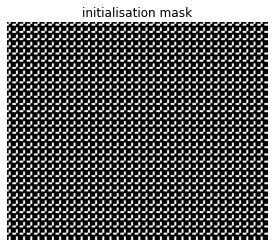

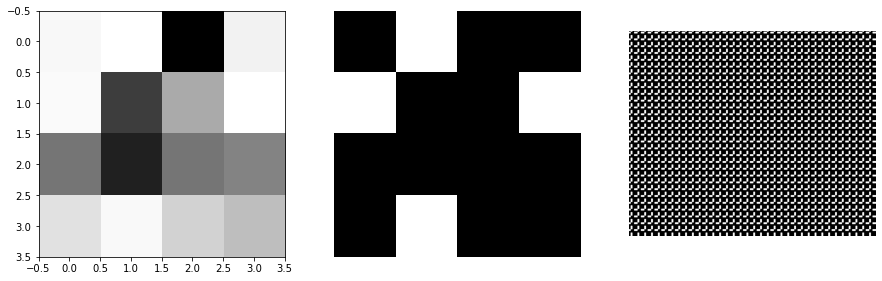

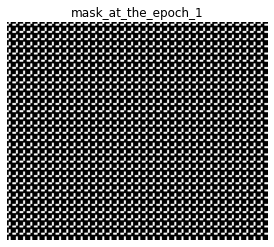

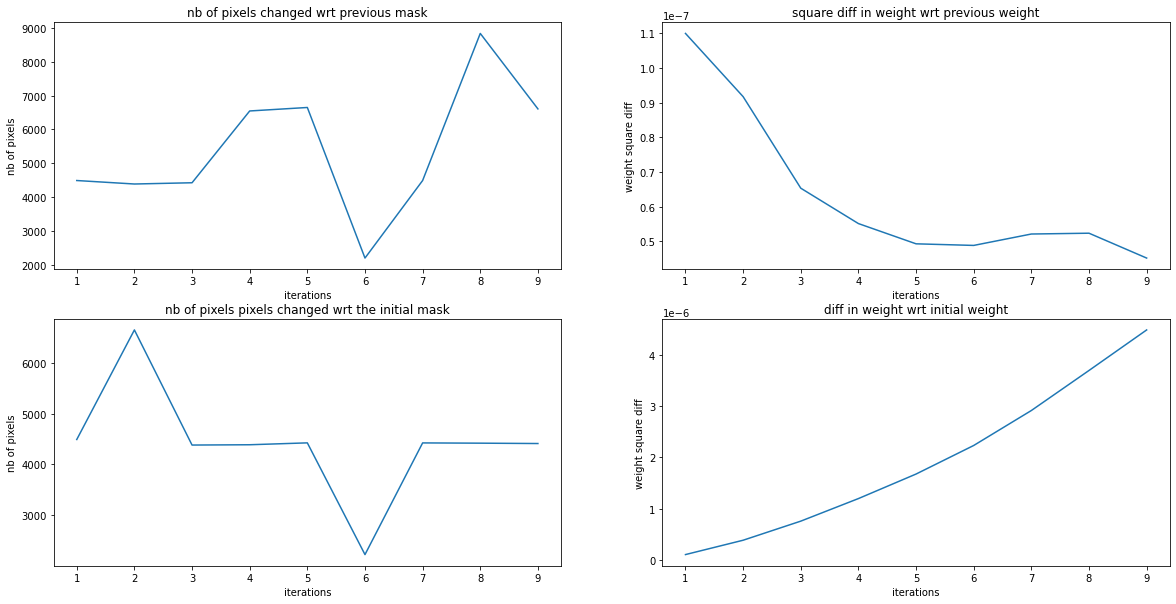

dictionay['test_loss'] [0.22030378878116608]


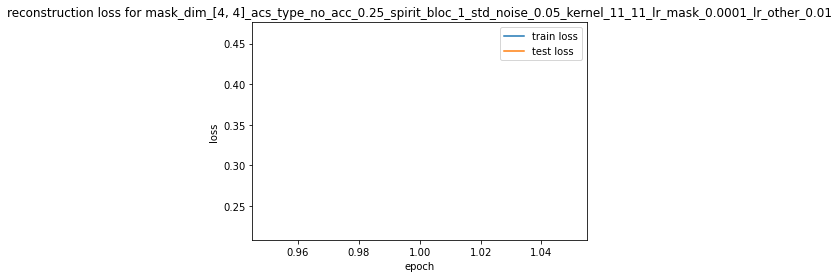

C:\Users\jeane\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")





Test set: Avg. loss: 0.2203


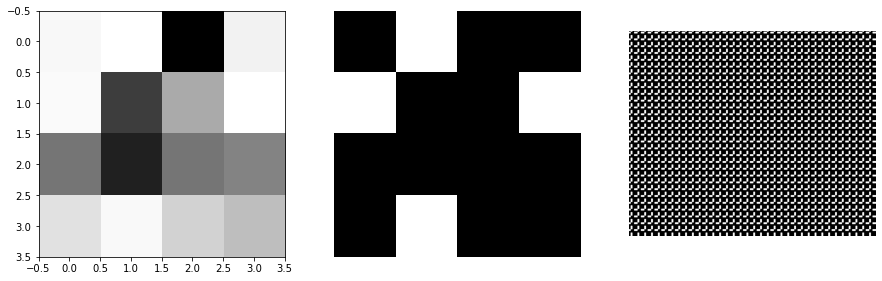

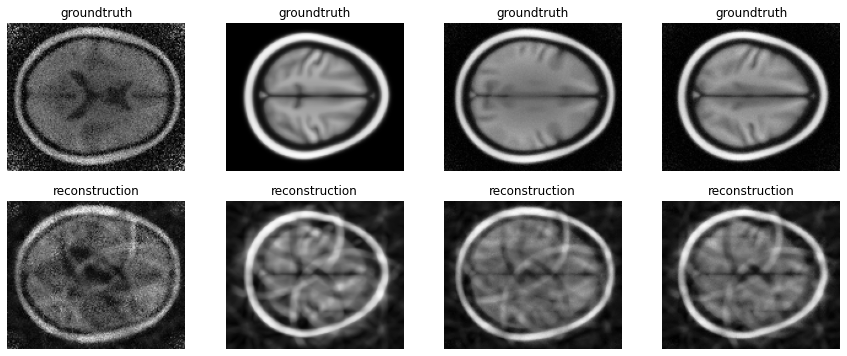

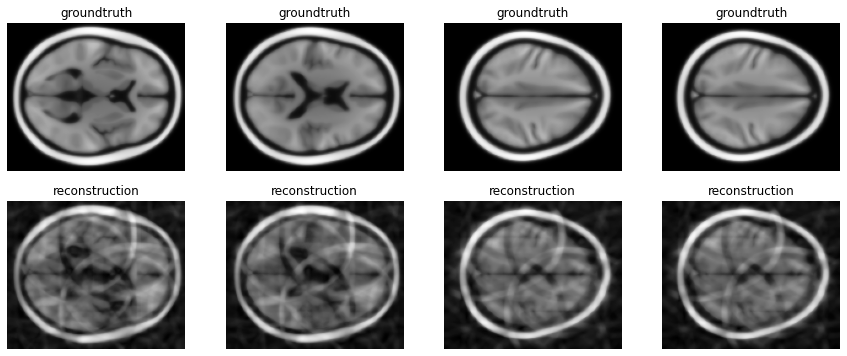

average ssim and psnr on test set {'test_ssim': 0.5125171747217449, 'test_psnr': 18.827332757442395}


<ipython-input-30-a9219437073e>:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(line, ignore_index=True)


In [34]:
##make acs depend on the acc 
config_mri1 = {"std_noise": 0.05,
 "decrease_std":False,          
 "std_start":0.20, #adapted for 50 epochs
 "std_end":0.05,
 "std_decay":12,
 "std_slope":5,        
          
 "dropout_proba": 0.0,
          
 "acc":0.25 ,
 "mask_dim": [4, 4], 
 "acs_full" :40,
 "acs_type": "no", 
              
 "slope": 1,
          
 "slice_dim": [121, 145], 
 "ncoils" : 8,
              
 "main_directory": "./result",
              
 "spirit_block": 1, 
 "kernel1": [11, 11], 

 "spirit_activation": "none",
 "batch_norm": False, "lr_mask": 1e-4, "lr_other": 1e-2, "auxiliary": False, 
 "normalized_mse" : True,
 "n_epochs":1,
          
 "batch_size_train":16,
 "batch_size_test":16 }

mask_learnlocal = run_model(config=config_mri1)

In [36]:
mask_learnlocal.shape

torch.Size([8, 1, 121, 145])

In [37]:
mask_learnlocal[0,0,:,:].sum()

tensor(4386.)

max on train data :  [0.97721912 0.79243795 0.65691147 0.81250615 0.99999937 0.79686517
 0.63735009 0.79842144] 
 min on train data :  [1.38879348e-11 1.22498695e-11 6.31889860e-12 4.25195137e-11
 6.69915921e-12 1.63238013e-11 1.56772965e-13 7.07815922e-11]
x_train shape : torch.Size([136, 8, 121, 145, 2])
#################################################################
mask_dim_[121, 145]_acs_type_no_acc_0.25_spirit_bloc_1_std_noise_0.05_kernel_11_11_lr_mask_0.0001_lr_other_0.01
Number of acquired points in the whole mask : 4386
Number of acquired points in the local mask of size [121, 145] : 4386
acceleration : 0.25


C:\Users\jeane\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



torch.Size([16, 8, 121, 145, 2])

Train Epoch: 1 [0/136 (0%)]	Loss: 0.8567








test at the end of epoch



Test set: Avg. loss: 0.7623


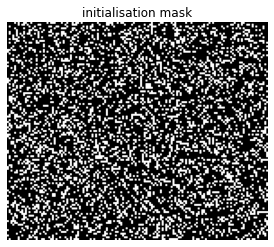

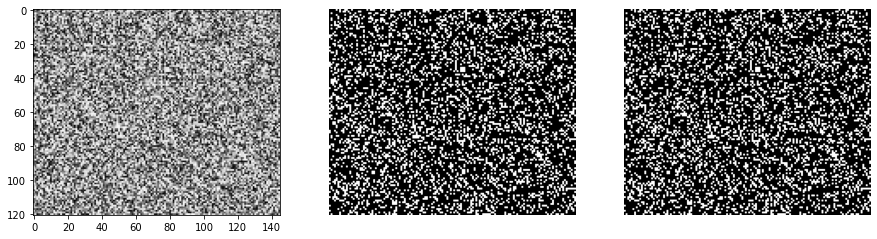


Train Epoch: 2 [0/136 (0%)]	Loss: 0.3939








test at the end of epoch



Test set: Avg. loss: 0.7434


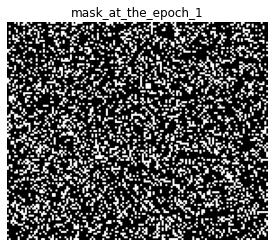

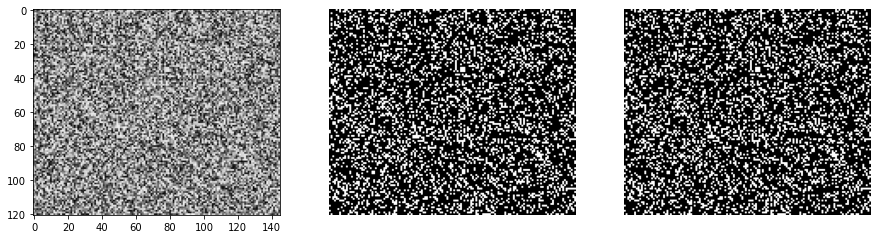

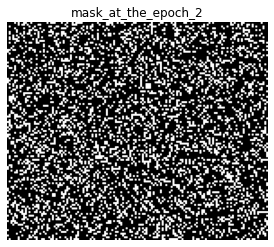

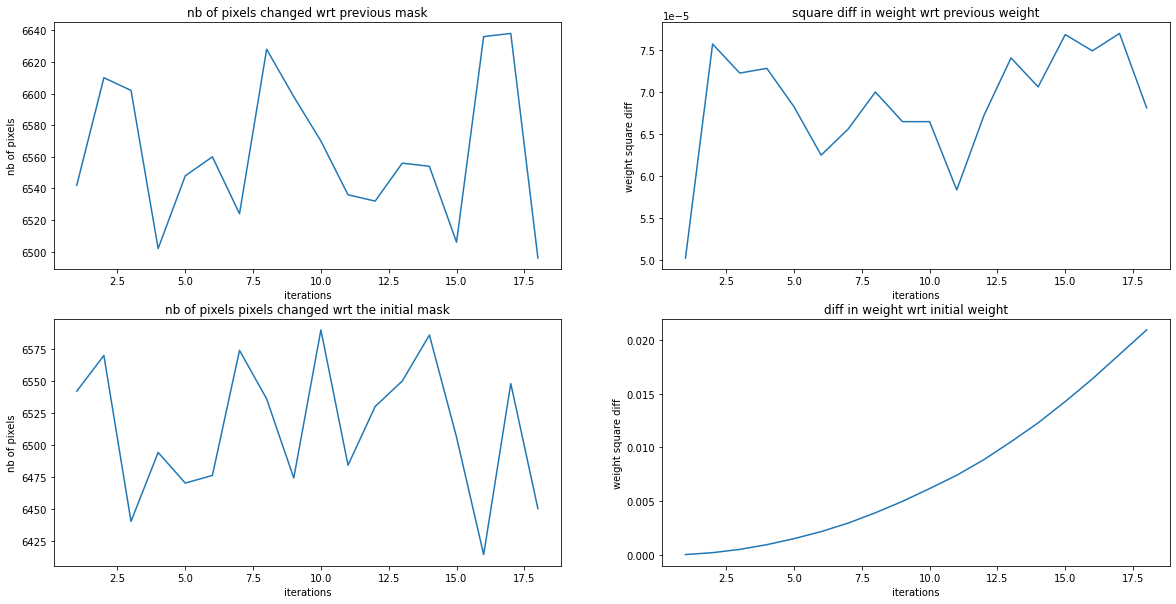

dictionay['test_loss'] [0.7623136043548584, 0.7433742880821228]


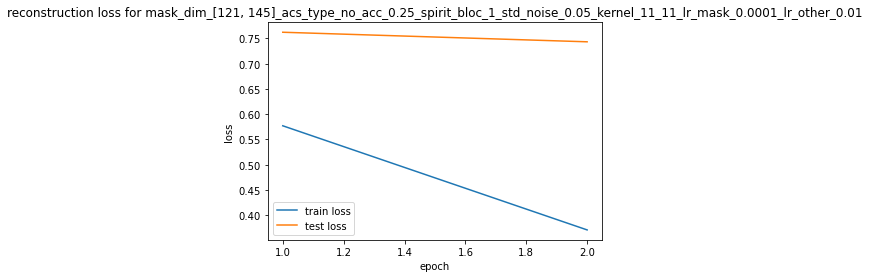

C:\Users\jeane\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")





Test set: Avg. loss: 0.7434


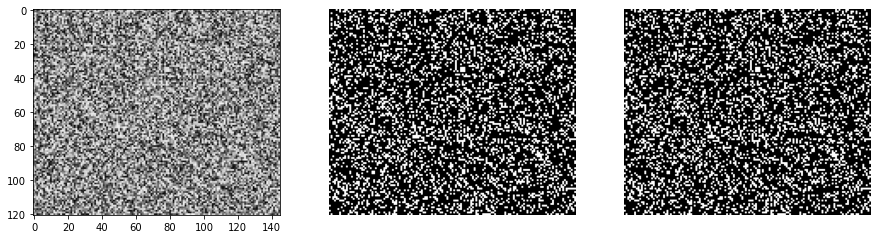

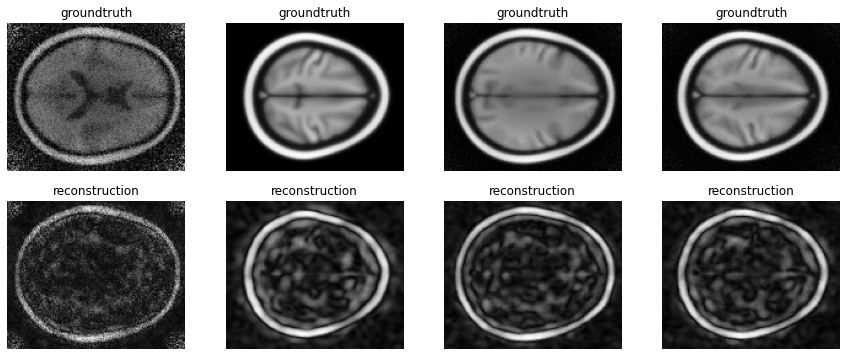

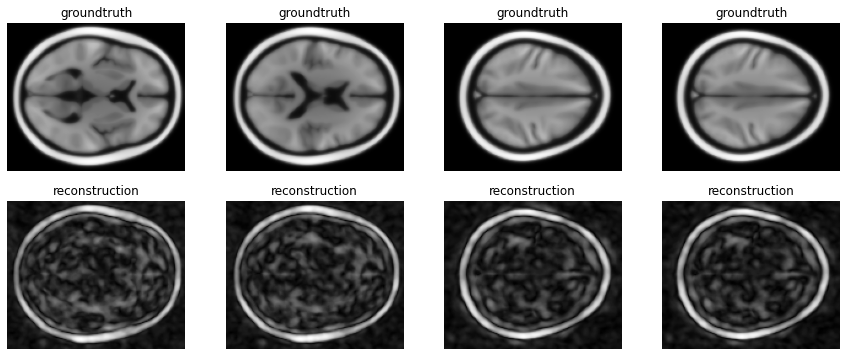

average ssim and psnr on test set {'test_ssim': 0.2374106111031586, 'test_psnr': 12.828094312121738}


<ipython-input-30-a9219437073e>:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(line, ignore_index=True)


In [41]:
##make acs depend on the acc 
config_mri2 = {"std_noise": 0.05,
 "decrease_std":False,          
 "std_start":0.20, #adapted for 50 epochs
 "std_end":0.05,
 "std_decay":12,
 "std_slope":5,        
          
 "dropout_proba": 0.0,
          
 "acc":0.25 ,
 "mask_dim": [121, 145], 
 "acs_full" :40,
 "acs_type": "no",
              
 "slope": 1,
          
 "slice_dim": [121, 145], 
 "ncoils" : 8,
              
 "main_directory": "./result",
              
 "spirit_block": 1, 
 "kernel1": [11, 11], 

 "spirit_activation": "none",
 "batch_norm": False, "lr_mask": 1e-4, "lr_other": 1e-2, "auxiliary": False, 
 "normalized_mse" : True,
 "n_epochs":2,
          
 "batch_size_train":16,
 "batch_size_test":16 }

mask_learnglobal = run_model(config=config_mri2)

In [42]:
mask_learnglobal[0,0,:,:].sum()

tensor(4386.)

## <font color='darkblue'> Fixed mask </font>

In [44]:
def create_mask(size, acceleration, typ, submask_size = (4,4),seed = None):
    """Create fixed mask pattern. This works finely for acceleration = 2 ie R =4 or 25% of data. For others acceleration, this doesn't work well. """
    num_cols = size[-1] 
    num_rows = size[-2]
    
        #acs_start = (num_cols - acs_lines + 1) // 2

    if typ=='uniform':

        mask_col = np.zeros(num_cols, dtype=bool)
        mask_col[::acceleration*2] = True
        ones = np.ones((num_rows,num_cols))
        mask = np.multiply(ones, mask_col)

    if typ == "2D_uniform":

        mask_row = np.zeros(num_rows, dtype=bool)
        mask_row[::acceleration] = True 
        mask_row ## indicates which lines in the first column are set to true or false

        mask_row = mask_row[:,None]
        mask_row

        mask_col = np.zeros(num_cols ,dtype=bool) ##indicate if each column has some acquired points or not at all
        mask_col[::acceleration] = True
        mask_col = np.tile(mask_col,(num_rows,1))
        mask_col

        mask = np.multiply(mask_row, mask_col)
        
    
    if typ == "caipiranha":

        ## caipiranha sampling mask , see https://mriquestions.com/caipirinha.html

        ##the goal is to build a small matrix (shape :(num_rows,accelaration)) which has a caipiranha pattern and then apply it to shape of the data

        mask_row = np.zeros(num_rows ,dtype=bool)
        mask_row[::acceleration] = True 
        mask_row = mask_row[:,None] ## indicates which lines in the first column are set to true or false

        mask_col = np.zeros(acceleration*2 ,dtype=bool)
        mask_col[::acceleration] = True
        mask_col = np.tile(mask_col,(num_rows,1))
        mask_col  ##assign true or false to each column

        dd = np.multiply(mask_row, mask_col) ##replecate the first column at columns which are set to true. dd is our small matrix that has a caipiranha pattern

        replace=(dd == False)[:,acceleration]  ## make a sampling shift : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3865024/ paragraph CAIPIRINHA Theory

        dd[:,acceleration] = replace

        mask = np.tile(dd,int(np.ceil(num_cols/dd.shape[1]))) ##replicate this matrix 

        mask = mask[:,:num_cols] #apply it to shape of the data
        #mask

    if typ == "random":

      k_per_under_mask = (submask_size[0]*submask_size[1])//4

      np.random.seed(seed)

      ##for the proportion we need to find the proportion of 1 we will have in a reference submask
      #https://stackoverflow.com/questions/19597473/binary-random-array-with-a-specific-proportion-of-ones

      #mask = np.random.choice([1, 0], size= size, p=[(acceleration*acceleration)/(submask_size[0]*submask_size[1]) , 1 - (acceleration*acceleration)/(submask_size[0]*submask_size[1])] )

      mask = np.array( [0] * (submask_size[0]*submask_size[1] - k_per_under_mask) + [1] * (k_per_under_mask) )
      
      np.random.shuffle(mask); mask = mask.reshape((submask_size[0],submask_size[1])); 

      mask = np.tile(mask, (math.ceil(num_rows/submask_size[0]),math.ceil(num_cols/submask_size[1])))[:num_rows,:num_cols] 

    return mask

## <font color='darkblue'> Define the reconstruction model with fixed mask

In [45]:
class FixmaskNet(nn.Module):

    def __init__(self, masque, config=None):
        super(FixmaskNet, self).__init__()

        self.img_h = config.slice_dim[0]
        self.img_w = config.slice_dim[1]

        self.height_mask = masque.shape[0]
        self.width_mask = masque.shape[1]
        
        self.acs = int(config.acs_full * 1/(config.acceleration*2)) ##here in fixed pattern we consider just an acceleration of 4 ie 2 on column and 2 on axis ==> 1/(config.acceleration*2) means a proportion of 25%
        
        self.config = config

        self.spirit_nn = stackSpirit(self.config)
        
        self.masque = torch.reshape(torch.from_numpy(masque), (1, 1, self.height_mask, self.width_mask))                       
        
        self.masque_adj = torch.tile(self.masque[:,:,], (math.ceil(self.img_h/self.height_mask),math.ceil(self.img_w/self.width_mask)))[:,:,:self.img_h,:self.img_w] # x shape :[batch_size,n_channel,h,w] ; x.shape[-2] =x.shape[-1] = 28

        
        if self.config.acs_type == "column":
          
            self.masque_adj[:, :, :, self.img_w//2 - self.acs//2 : self.img_w//2 + self.acs//2 +1] = 1 ##acs columns; with this large number the sigmoide should be close to 1
                #print("acs nb col :", (self.w//2 + self.acs//2 +1) - (self.w//2 - self.acs//2))
                
        elif self.config.acs_type == "square":
      
            self.masque_adj[:, :, self.img_h//2 - self.acs//2 : self.img_h//2 + self.acs//2 +1, self.img_w//2 - self.acs//2 : self.img_w//2 + self.acs//2 +1] = 1                                        
                #print("acs shape :", (self.h//2 + self.acs//2 +1) - (self.h//2 - self.acs//2) , " ", (self.w//2 + self.acs//2 +1)- (self.w//2 - self.acs//2))
                
        elif self.config.acs_type == "no": 
            pass

        self.stack_binary_mask_adj = torch.stack((self.masque_adj, self.masque_adj), dim=-1,).float().to(device)

        
    def forward(self, x):

        x  = torch.mul(self.stack_binary_mask_adj, x)

        reconstructed_img = self.spirit_nn(x, self.stack_binary_mask_adj) ##more precisely it is the reconstructed kspace  
          
        return reconstructed_img , self.masque_adj, self.masque  

## <font color='darkblue'> Run model for fixed mask

In [46]:
    
def run_fix_mask_model_2(config, trainset= k_space_data_train, testset = k_space_data_test, critere = nn.MSELoss().to(device)):
    
    config = edict(config.copy()) 
    
    dir_name = f"acs_type_{config.acs_type}_mask_typ_{config.mask_typ}_mask_seed_{config.mask_seed}_mask_dim_{config.mask_dim[0]}_{config.mask_dim[1]}_spirit_bloc_{config.spirit_block}_kernel_{config.kernel1[0]}_{config.kernel1[1]}_lr_other_{config.lr_other}"
    
    
    try:
        os.mkdir(config.main_directory) ##this will be created once, the others times an error will occur due to the multiplication of config that will need to create it again
    except:
        pass
        

    try:
        save_path = os.path.join(config.main_directory, dir_name)
        os.mkdir(save_path)  
    except:
        pass


    mask = create_mask(config.mask_dim, acceleration=2, typ=config.mask_typ, submask_size = (4,4),seed = config.mask_seed)
    
    print("#################################################################")                          

    print(f"acs_type_{config.acs_type}_mask_typ_{config.mask_typ}_mask_seed_{config.mask_seed}_mask_dim_{config.mask_dim}_spirit_bloc_{config.spirit_block}_lr_other_{config.lr_other}_kernel_{config.kernel1}")
    
    
    df = pd.DataFrame(columns=['acs_type','mask_typ','mask_seed','mask_dim','bloc', 'kernel','lr_other','test_ssim','test_psnr','test_loss','test_loss_denorm'])
    
        
    ##initialize scaler
    init_scaler = own_minmaxscaler(config)
    
    train_loader, test_loader, input_scaler = transform_data(trainset, testset,config, init_scaler)                          
        
    reconst_network = FixmaskNet(mask, config = config).to(device)    

        ##Initialize spirit weights
    for m in reconst_network.modules():  ## from self.netS.apply(weights_init) mriPatchGanSpirit.py ; Pytorch-MRI-ML-recon-V1.1/graphs/weights_initializer.py
    
        if (type(m) in [nn.Conv2d]): 
            m.weight.data.normal_(0.0, 0.02)
    
    
    optimizer = optim.Adam(reconst_network.parameters(), lr= config.lr_other)
    
    print("start running")

    history = train_spirit_2(config.n_epochs, network = reconst_network,optimizer = optimizer,config = config, loader =train_loader, loader_test= test_loader, scaler = input_scaler, criterion=critere, saving_path = save_path ,fix_mask = True)
    
    plot_loss(history, title=f"reconstruction loss_spirit_bloc_{config.spirit_block}_lr_other_{config.lr_other}_kernel_{config.kernel1[0]}_{config.kernel1[1]}", test=True, saving_path = os.path.join(save_path,"loss_curve.png") )

    test_input, test_output,test_loss, finalmask = test_spirit_2(reconst_network,criterion=critere, config =config, loader = test_loader,scaler = input_scaler, fix_mask = True)    


    plotting_reconst(test_input , test_output,mask =finalmask,loader=test_loader, n=4, seed= 815, saving_path =os.path.join(save_path,"reconst_examples1.png"))
    
    plotting_reconst(test_input , test_output,mask =finalmask,loader=test_loader, n=4, seed= 23, saving_path =os.path.join(save_path,"reconst_examples2.png"))

    plotting_reconst(test_input , test_output,mask =finalmask,loader=test_loader, n=4, seed= 100, saving_path =os.path.join(save_path,"reconst_examples3.png"))

    metrics = compute_ssim(test_input ,test_output)
    
    test_loss_denorm = critere(torch.from_numpy(test_input), torch.from_numpy(test_output)).item()

    print("average ssim and psnr on test set", metrics)    
    
    line ={"acs_type":config.acs_type,"mask_typ":config.mask_typ,"mask_seed":config.mask_seed ,"mask_dim":config.mask_dim ,"bloc" : config.spirit_block, "kernel" :config.kernel1,"lr_other": config.lr_other}

    line.update(metrics); line["test_loss"] = test_loss ; line["test_loss_denorm"] = test_loss_denorm

    df = df.append(line, ignore_index=True) 

    df.to_csv(os.path.join(config.main_directory, dir_name ,"result_grid_search.csv"), sep='\t',index=True)           
    

    print("##########   FIN   ##########")
    
    return finalmask


#################################################################
acs_type_no_mask_typ_uniform_mask_seed_None_mask_dim_[4, 4]_spirit_bloc_1_lr_other_0.01_kernel_[11, 11]
max on train data :  [0.97721912 0.79243795 0.65691147 0.81250615 0.99999937 0.79686517
 0.63735009 0.79842144] 
 min on train data :  [1.38879348e-11 1.22498695e-11 6.31889860e-12 4.25195137e-11
 6.69915921e-12 1.63238013e-11 1.56772965e-13 7.07815922e-11]
x_train shape : torch.Size([136, 8, 121, 145, 2])
start running
Train Epoch: 1 [0/136 (0%)]	Loss: 0.7707
test at the end of epoch

Test set: Avg. loss: 0.1799


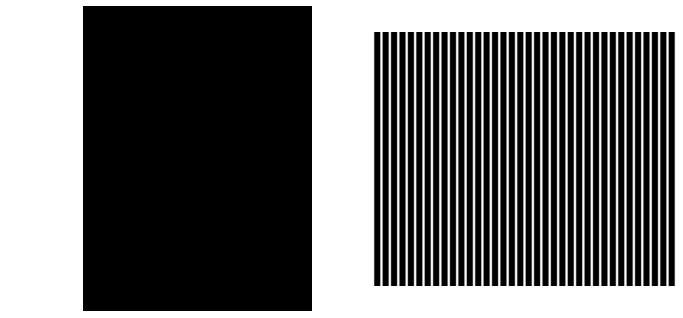

dictionay['test_loss'] [0.17991648614406586]


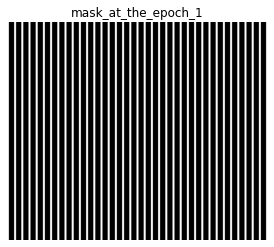

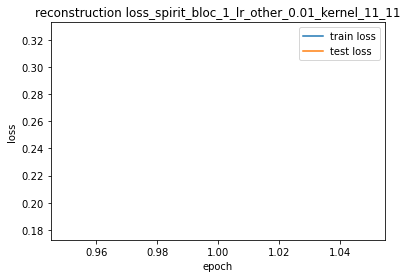


Test set: Avg. loss: 0.1799


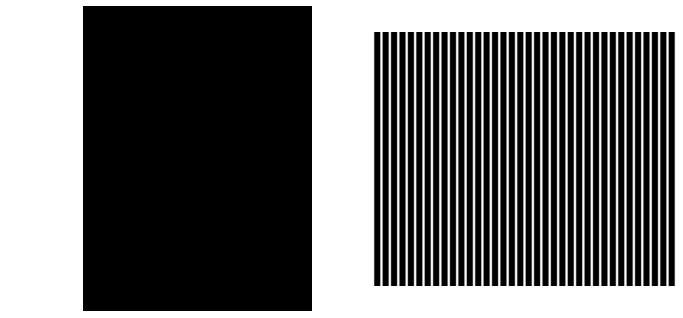

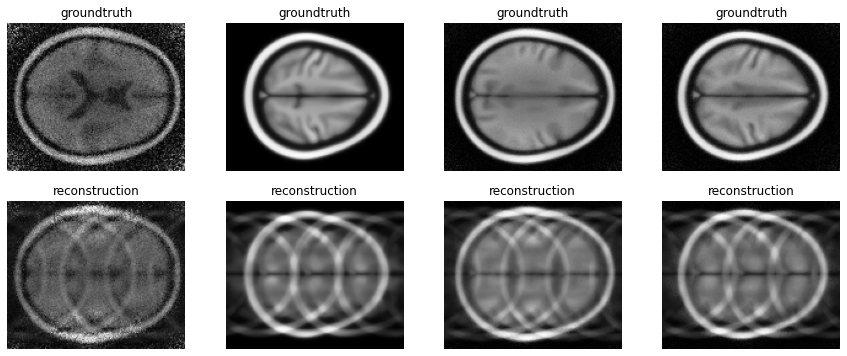

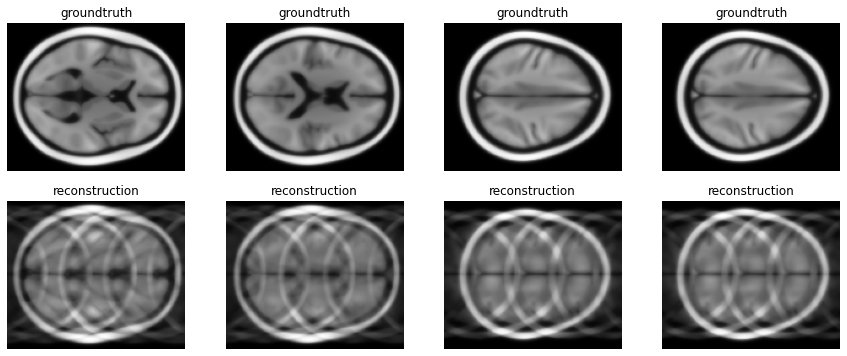

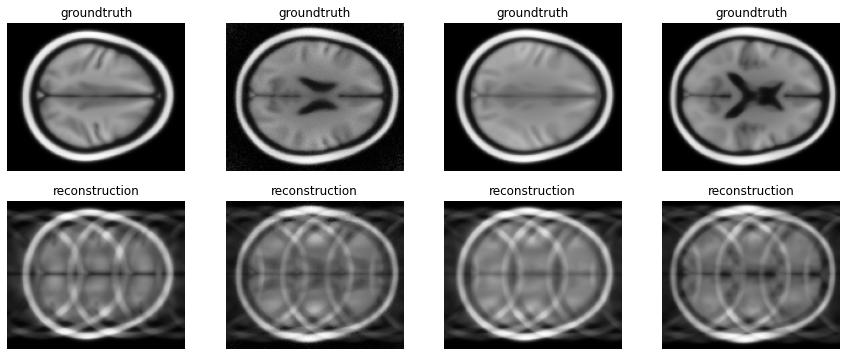

average ssim and psnr on test set {'test_ssim': 0.5023578772595847, 'test_psnr': 18.40796025628536}
##########   FIN   ##########


<ipython-input-46-6575177a4cc4>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(line, ignore_index=True)


In [47]:
config_mri = { "mask_seed": None,      
"mask_typ": "uniform",           
"decrease_std":False,           
 "acceleration": 2, ### for the fixed mask, we only consider the acceleration 4 , here 2 is for acceleration = 2 on rows and 2 on column, which leads to 4
 "mask_dim": [4, 4], 
 "acs_full" :40, ## we choose an acs region of size 40*40. This will be reduced in function of the acceleration
 "acs_type": "no",
              
 "slope": 1,
          
 "slice_dim": [121, 145], 
 "ncoils" : 8,
              
 "main_directory": "./result",
              
 "spirit_block": 1, 
 "kernel1": [11, 11], 

 "lr_other": 1e-2, 
 "normalized_mse" : True,
 "n_epochs":1,
          
 "batch_size_train":16,
 "batch_size_test":16 }

mask_uniform = run_fix_mask_model_2(config = config_mri)


In [48]:
mask_uniform.sum()

tensor(4477., dtype=torch.float64)

#################################################################
acs_type_no_mask_typ_2D_uniform_mask_seed_None_mask_dim_[4, 4]_spirit_bloc_1_lr_other_0.01_kernel_[11, 11]
max on train data :  [0.97721912 0.79243795 0.65691147 0.81250615 0.99999937 0.79686517
 0.63735009 0.79842144] 
 min on train data :  [1.38879348e-11 1.22498695e-11 6.31889860e-12 4.25195137e-11
 6.69915921e-12 1.63238013e-11 1.56772965e-13 7.07815922e-11]
x_train shape : torch.Size([136, 8, 121, 145, 2])
start running
Train Epoch: 1 [0/136 (0%)]	Loss: 0.8559
test at the end of epoch

Test set: Avg. loss: 0.1734


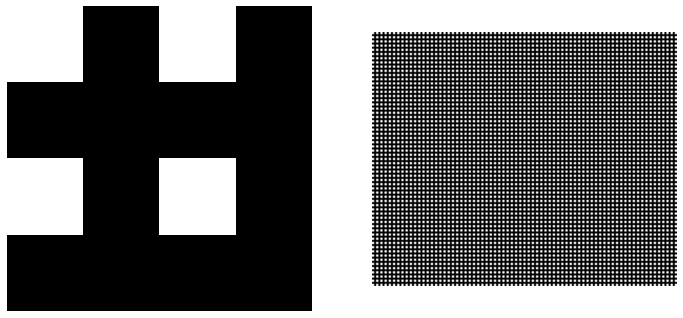

dictionay['test_loss'] [0.17338186502456665]


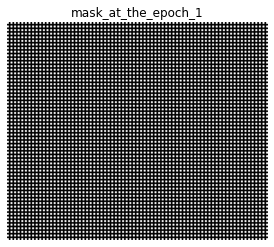

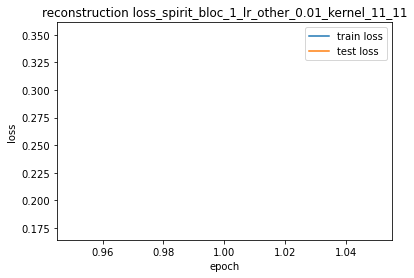


Test set: Avg. loss: 0.1734


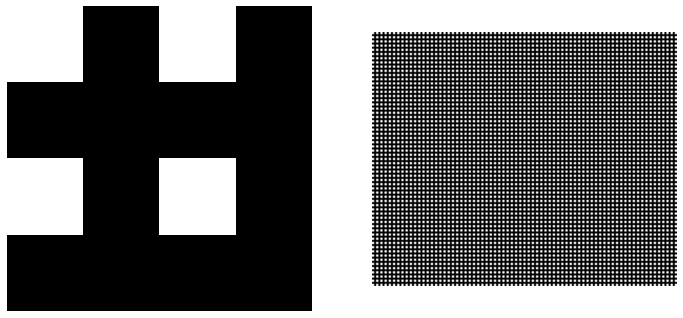

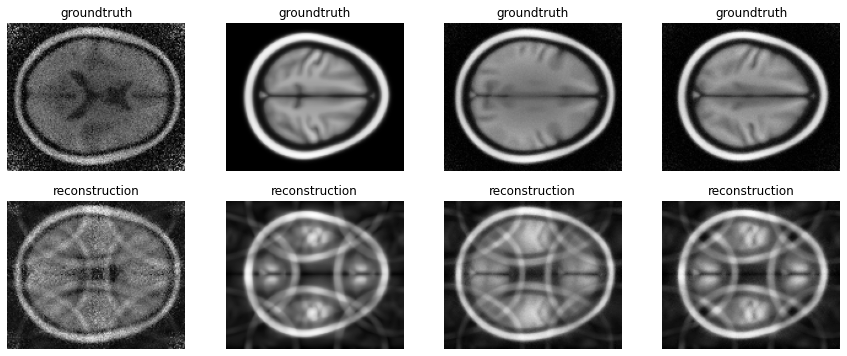

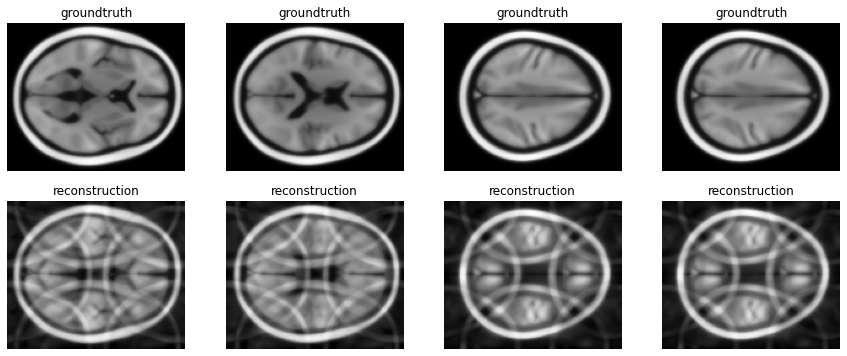

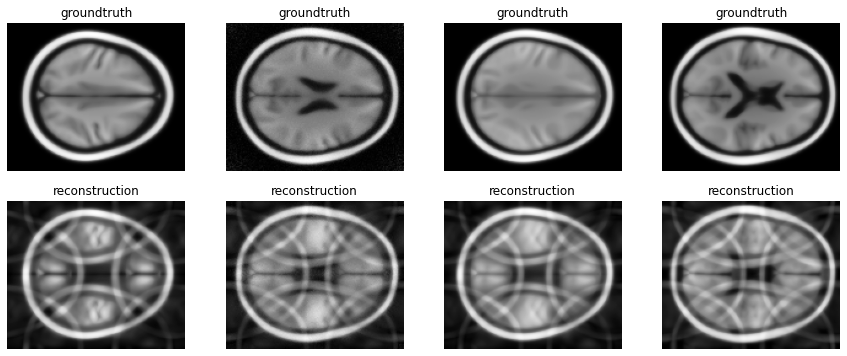

average ssim and psnr on test set {'test_ssim': 0.5078715649886512, 'test_psnr': 19.19712570051956}
##########   FIN   ##########


<ipython-input-46-6575177a4cc4>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(line, ignore_index=True)


In [50]:
config_mri = { "mask_seed": None,      
"mask_typ": "2D_uniform",           
"decrease_std":False,           
 "acceleration": 2, ### for the fixed mask, we only consider the acceleration 4 , here 2 is for acceleration = 2 on rows and 2 on column, which leads to 4
 "mask_dim": [4, 4], 
 "acs_full" :40,
 "acs_type": "no",
              
 "slope": 1,
          
 "slice_dim": [121, 145], 
 "ncoils" : 8,
              
 "main_directory": "./result",
              
 "spirit_block": 1, 
 "kernel1": [11, 11], 

 "lr_other": 1e-2, 
 "normalized_mse" : True,
 "n_epochs":1,
          
 "batch_size_train":16,
 "batch_size_test":16 }

mask_2D_uniform = run_fix_mask_model_2(config = config_mri)



In [51]:
mask_2D_uniform.sum()

tensor(4453)

#################################################################
acs_type_no_mask_typ_caipiranha_mask_seed_None_mask_dim_[4, 4]_spirit_bloc_1_lr_other_0.01_kernel_[11, 11]
max on train data :  [0.97721912 0.79243795 0.65691147 0.81250615 0.99999937 0.79686517
 0.63735009 0.79842144] 
 min on train data :  [1.38879348e-11 1.22498695e-11 6.31889860e-12 4.25195137e-11
 6.69915921e-12 1.63238013e-11 1.56772965e-13 7.07815922e-11]
x_train shape : torch.Size([136, 8, 121, 145, 2])
start running
Train Epoch: 1 [0/136 (0%)]	Loss: 0.8108
test at the end of epoch

Test set: Avg. loss: 0.1795


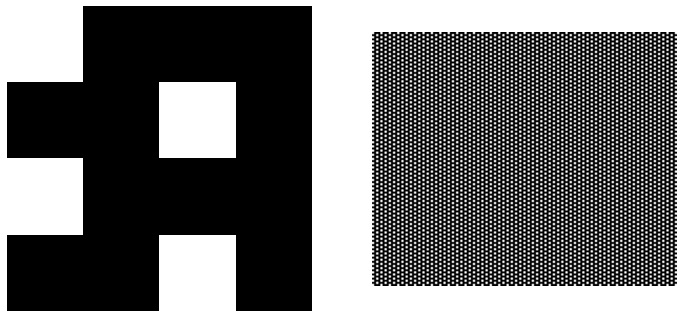

dictionay['test_loss'] [0.1794615536928177]


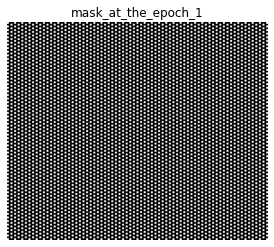

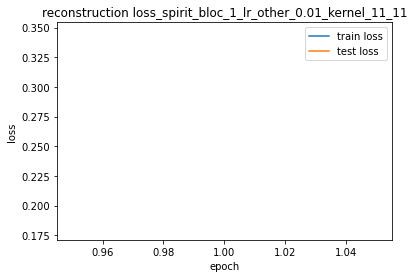


Test set: Avg. loss: 0.1795


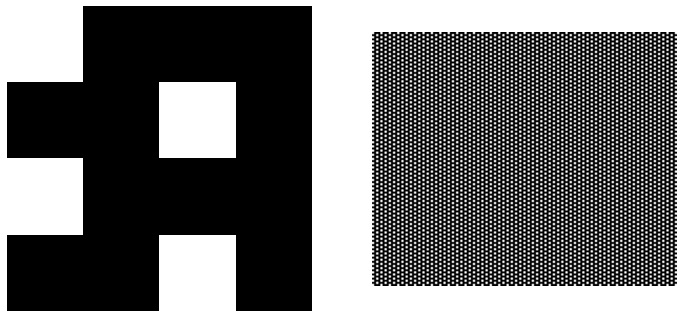

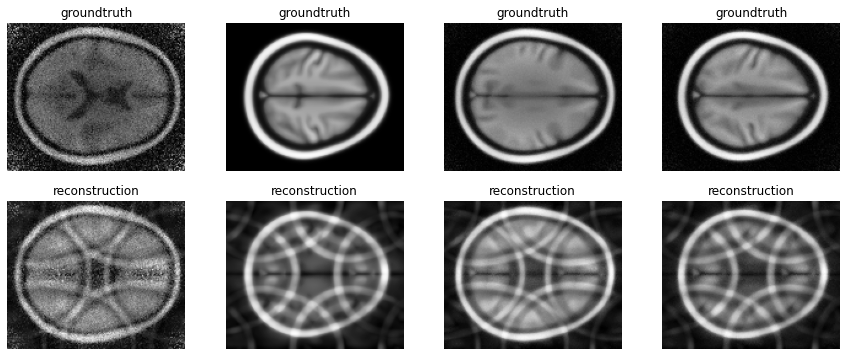

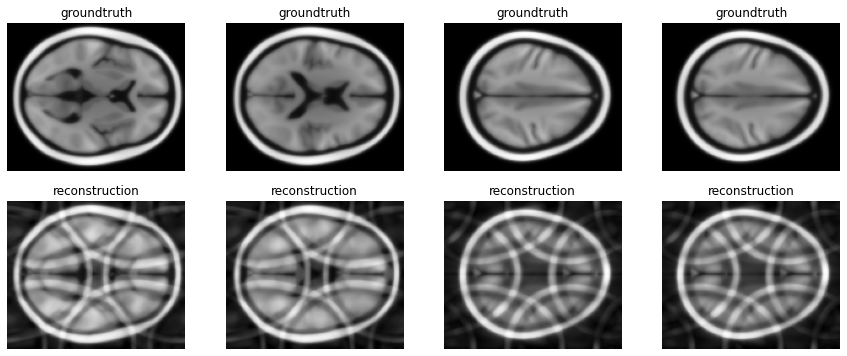

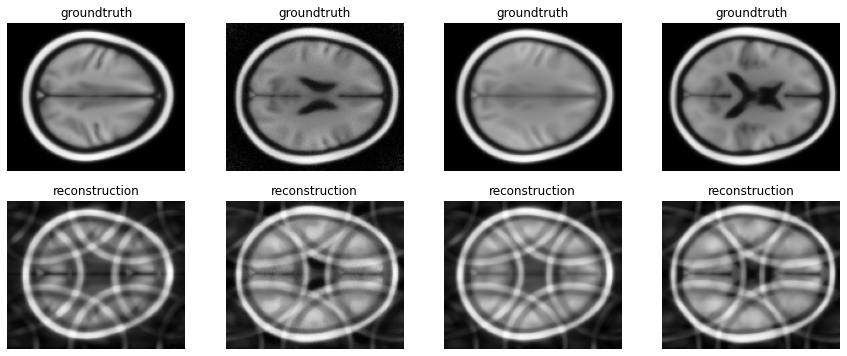

average ssim and psnr on test set {'test_ssim': 0.5111041648193765, 'test_psnr': 18.61786298949386}
##########   FIN   ##########


<ipython-input-46-6575177a4cc4>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(line, ignore_index=True)


In [52]:
config_mri = { "mask_seed": None,      
"mask_typ": "caipiranha",           
"decrease_std":False,           
 "acceleration": 2, ### for the fixed mask, we only consider the acceleration 4 , here 2 is for acceleration = 2 on rows and 2 on column, which leads to 4
 "mask_dim": [4, 4], 
 "acs_full" :40,
 "acs_type": "no",
              
 "slope": 1,
          
 "slice_dim": [121, 145], 
 "ncoils" : 8,
              
 "main_directory": "./result",
              
 "spirit_block": 1, 
 "kernel1": [11, 11], 

 "lr_other": 1e-2, 
 "normalized_mse" : True,
 "n_epochs":1,
          
 "batch_size_train":16,
 "batch_size_test":16 }

mask_caipiranha = run_fix_mask_model_2(config = config_mri)


In [53]:
mask_caipiranha.sum()

tensor(4417)

In [118]:
import json

config_mri = { "mask_seed": None,      
"mask_typ": "uniform",           
"decrease_std":False,           
 "acceleration": 2, ### for the fixed mask, we only consider the acceleration 4 , here 2 is for acceleration = 2 on rows and 2 on column, which leads to 4
 "mask_dim": [4, 4], 
 "acs_full" :40,
 "acs_type": "square",
              
 "slope": 1,
          
 "slice_dim": [121, 145], 
 "ncoils" : 8,
              
 "main_directory": "./result",
              
 "spirit_block": 1, 
 "kernel1": [11, 11], 

 "lr_other": 1e-2, 
 "normalized_mse" : True,
 "n_epochs":3,
          
 "batch_size_train":16,
 "batch_size_test":16 }

with open("C:/Users/jeane/_stage_IAAA/mri-dl-amu-2020/Pytorch-MRI-ML-recon-V1.1/experiment on mri/mask_fixed_normalize_mri/config_fixedmask.json", 'w') as fp:
    json.dump(config_mri, fp)

In [ ]:
##make acs depend on the acc 
config_mri = {"std_noise": 0.05,
 "decrease_std":False,          
 "std_start":0.20, #adapted for 50 epochs
 "std_end":0.05,
 "std_decay":12,
 "std_slope":5,        
          
 "dropout_proba": 0.0,
          
 "acc":0.25 ,
 "mask_dim": [121, 145], 
 "acs_full" :40,
 "acs_type": "square",
              
 "slope": 1,
          
 "slice_dim": [121, 145], 
 "ncoils" : 8,
              
 "main_directory": "./result",
              
 "spirit_block": 1, 
 "kernel1": [11, 11], 

 "spirit_activation": "none",
 "batch_norm": False, "lr_mask": 1e-4, "lr_other": 1e-2, "auxiliary": False, 
 "normalized_mse" : True,
 "n_epochs":2,
          
 "batch_size_train":16,
 "batch_size_test":16 }